## Packages

In [1]:
# to speed-up execution, mark this as True
USE_CACHED_RESULTS=False

In [2]:
import maxent
import maxentep as py0
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyabc
import os
import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')

## Set-up SEAIR Model

In [3]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)

[4241. 3868. 1023.] [144101. 110004. 124468.]


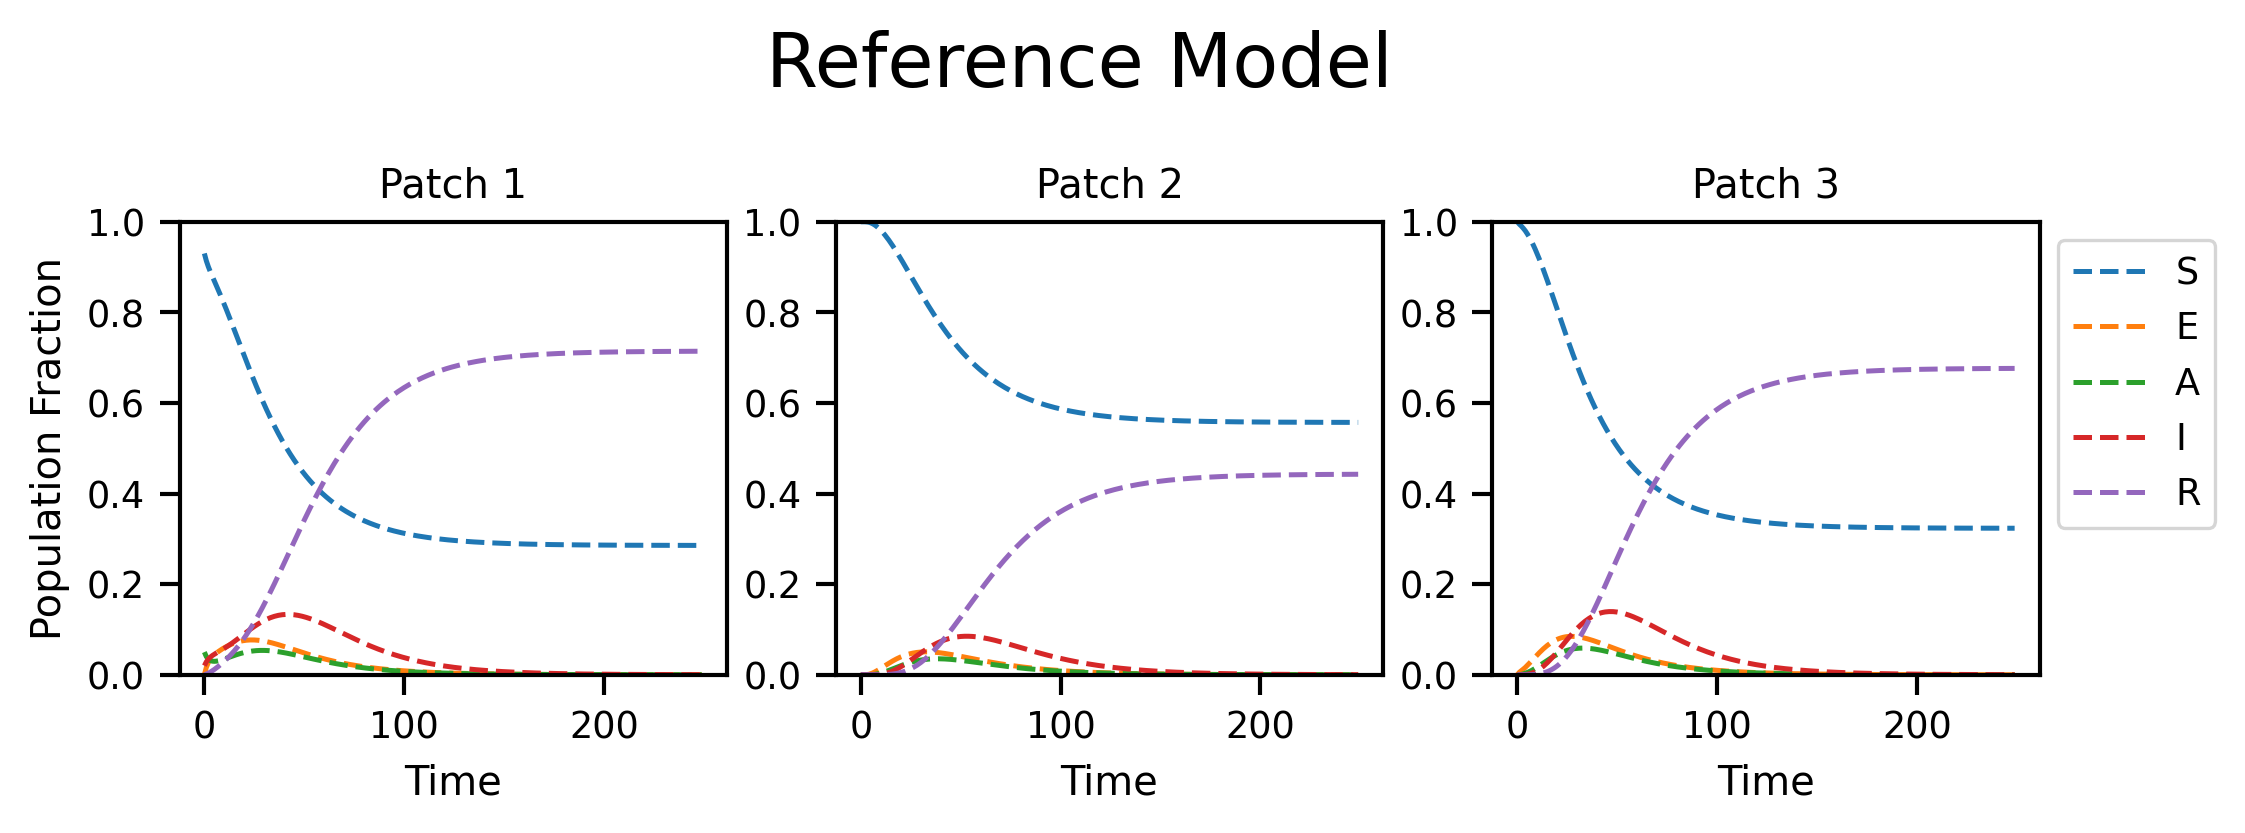

In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
infect_fxn = py0.contact_infection_func(infections_compartments)
full_compartments = ['S'] + compartments
R = np.array([[1000, 400, 10],
         [0, 300, 300],
         [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    timesteps = 250
    meta_model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
ref_inpputs = [0.02, 0.05, 7, 5, 14]
ref_traj = metapop_wraper(*ref_inpputs )
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--', label=full_compartments)
axs[0].set_ylabel('Population Fraction')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [5]:
npoints = 5
np.random.seed(0)
prior = maxent.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300826 0.10784731813725082
45 0.13207552 0.1526054434665933
31 0.12169184 0.12889401646488136
80 0.06942835 0.1421420223992924
17 0.08018874 0.11824062257689161


## Sample SEAIR Trajectories

In [6]:
tf.random.set_seed(0)
if not USE_CACHED_RESULTS or not os.path.exists('epidemiology_files/maxent_sample_trajs'):
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1)
    tmat.add_transition('A', 'I', 2, 4)
    tmat.add_transition('I', 'R', 10, 5)
    start_logits = np.zeros((M))
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_var = 0.9
    hyper_pram.beta_start = 0.01
    hyper_pram.beta_high = 0.15
    hyper_pram.beta_low = 0.001
    hyper_pram.start_mean = 0.001
    hyper_pram.start_high = 0.4
    hyper_pram.start_var = 0.8
    param_model = py0.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)
    # Fxing beta and mobility matrix
    R_norm_sample = tf.convert_to_tensor(R_norm)
    beta_sample = tf.convert_to_tensor([0.025])
    N = 2048
    batches = 4
    batch_size = N*batches
    outs = []
    timesteps = 250
    model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    for b in tqdm.tqdm(range(batches)):
        psample = param_model.sample(N)
        psample[0] = tf.repeat(R_norm_sample[tf.newaxis,:], len(psample[0]), axis =0) 
        psample[3] = tf.repeat(beta_sample[tf.newaxis,:], len(psample[0]), axis =0)
        outs.append(model(*psample))
    trajs = np.concatenate(outs, axis=0)
    np.save('epidemiology_files/maxent_sample_trajs', trajs)
else:
    trajs = np.load('epidemiology_files/maxent_sample_trajs.npy')


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]


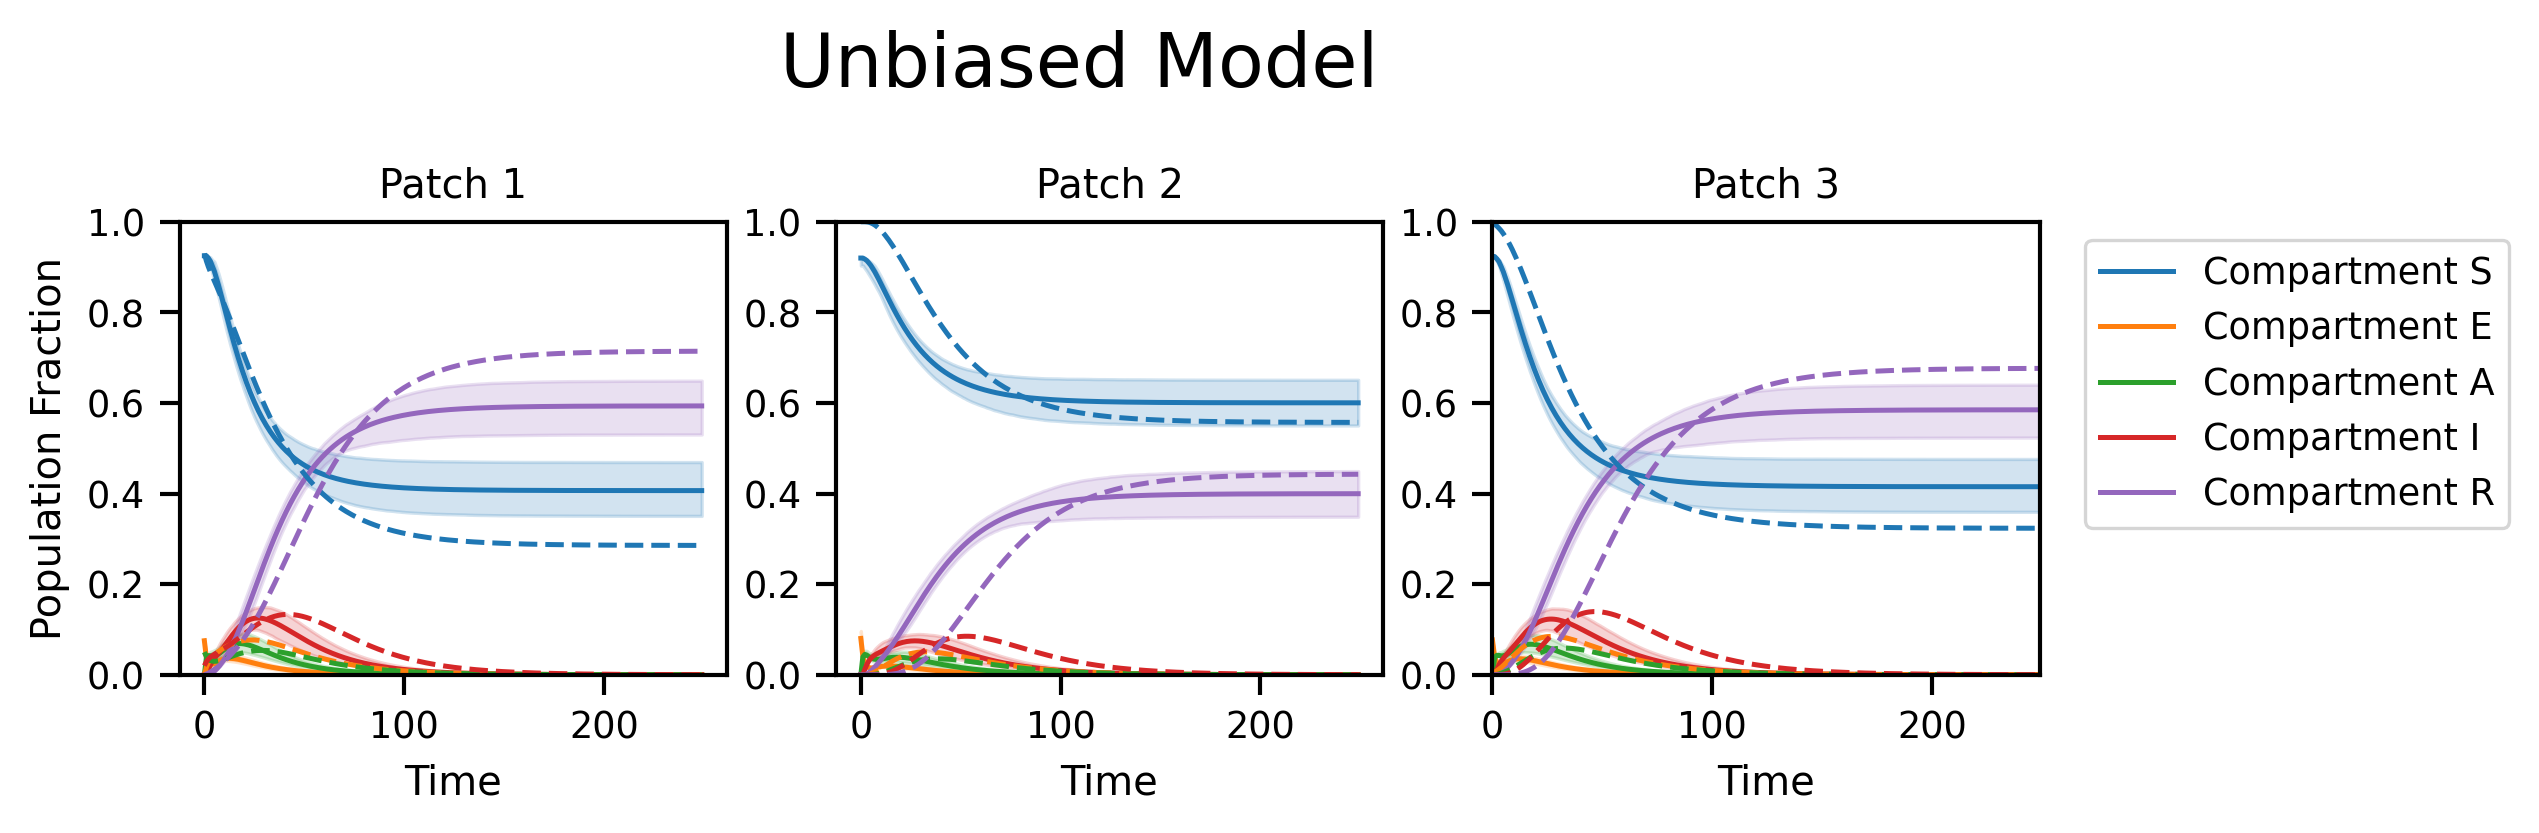

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

In [8]:
if not USE_CACHED_RESULTS:
    me_model = maxent.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)
    me_w = me_model.traj_weights
    np.save('epidemiology_files/maxent_biased_me_w', me_w)
else:
    me_w = np.load('epidemiology_files/maxent_biased_me_w.npy')

Epoch 1/1000
1/1 [==============================] - 1s 615ms/step - loss: 0.0043 - weight-entropy: 9.0092
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 9.0100
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0040 - weight-entropy: 9.0104
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 9.0099
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 9.0089
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0038 - weight-entropy: 9.0074
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 9.0055
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 9.0030
Epoch 10/1000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4864
Epoch 80/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4832
Epoch 81/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4802
Epoch 82/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4772
Epoch 83/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0018 - weight-entropy: 8.4743
Epoch 84/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4716
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4689
Epoch 86/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4663
Epoch 87/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4638
Epoch 88/1000
1/1 [==============================] - 0s 3ms/step - lo

1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2941
Epoch 234/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2933
Epoch 235/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2924
Epoch 236/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2916
Epoch 237/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2907
Epoch 238/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2899
Epoch 239/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2890
Epoch 240/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2882
Epoch 241/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.2873
Epoch 242/1000
1/1 [==============================] - 0s 2ms/

Epoch 387/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1773
Epoch 388/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1766
Epoch 389/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1760
Epoch 390/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1753
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1746
Epoch 392/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1740
Epoch 393/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1733
Epoch 394/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.1726
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1720
Epoch 396/1000
1/1 [==========================

1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0838
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0832
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0826
Epoch 544/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0820
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0815
Epoch 546/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0809
Epoch 547/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0803
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0797
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0791
Epoch 550/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9793
Epoch 696/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9784
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9775
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9766
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9757
Epoch 700/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9748
Epoch 701/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9739
Epoch 702/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9730
Epoch 703/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.9721
Epoch 704/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7886
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7870
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7854
Epoch 852/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7837
Epoch 853/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7821
Epoch 854/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7805
Epoch 855/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7788
Epoch 856/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7772
Epoch 857/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7755
Epoch 858/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 8.6859e-04 - weight-entropy: 7.5021
Epoch 999/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.6757e-04 - weight-entropy: 7.5000
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.6653e-04 - weight-entropy: 7.4978


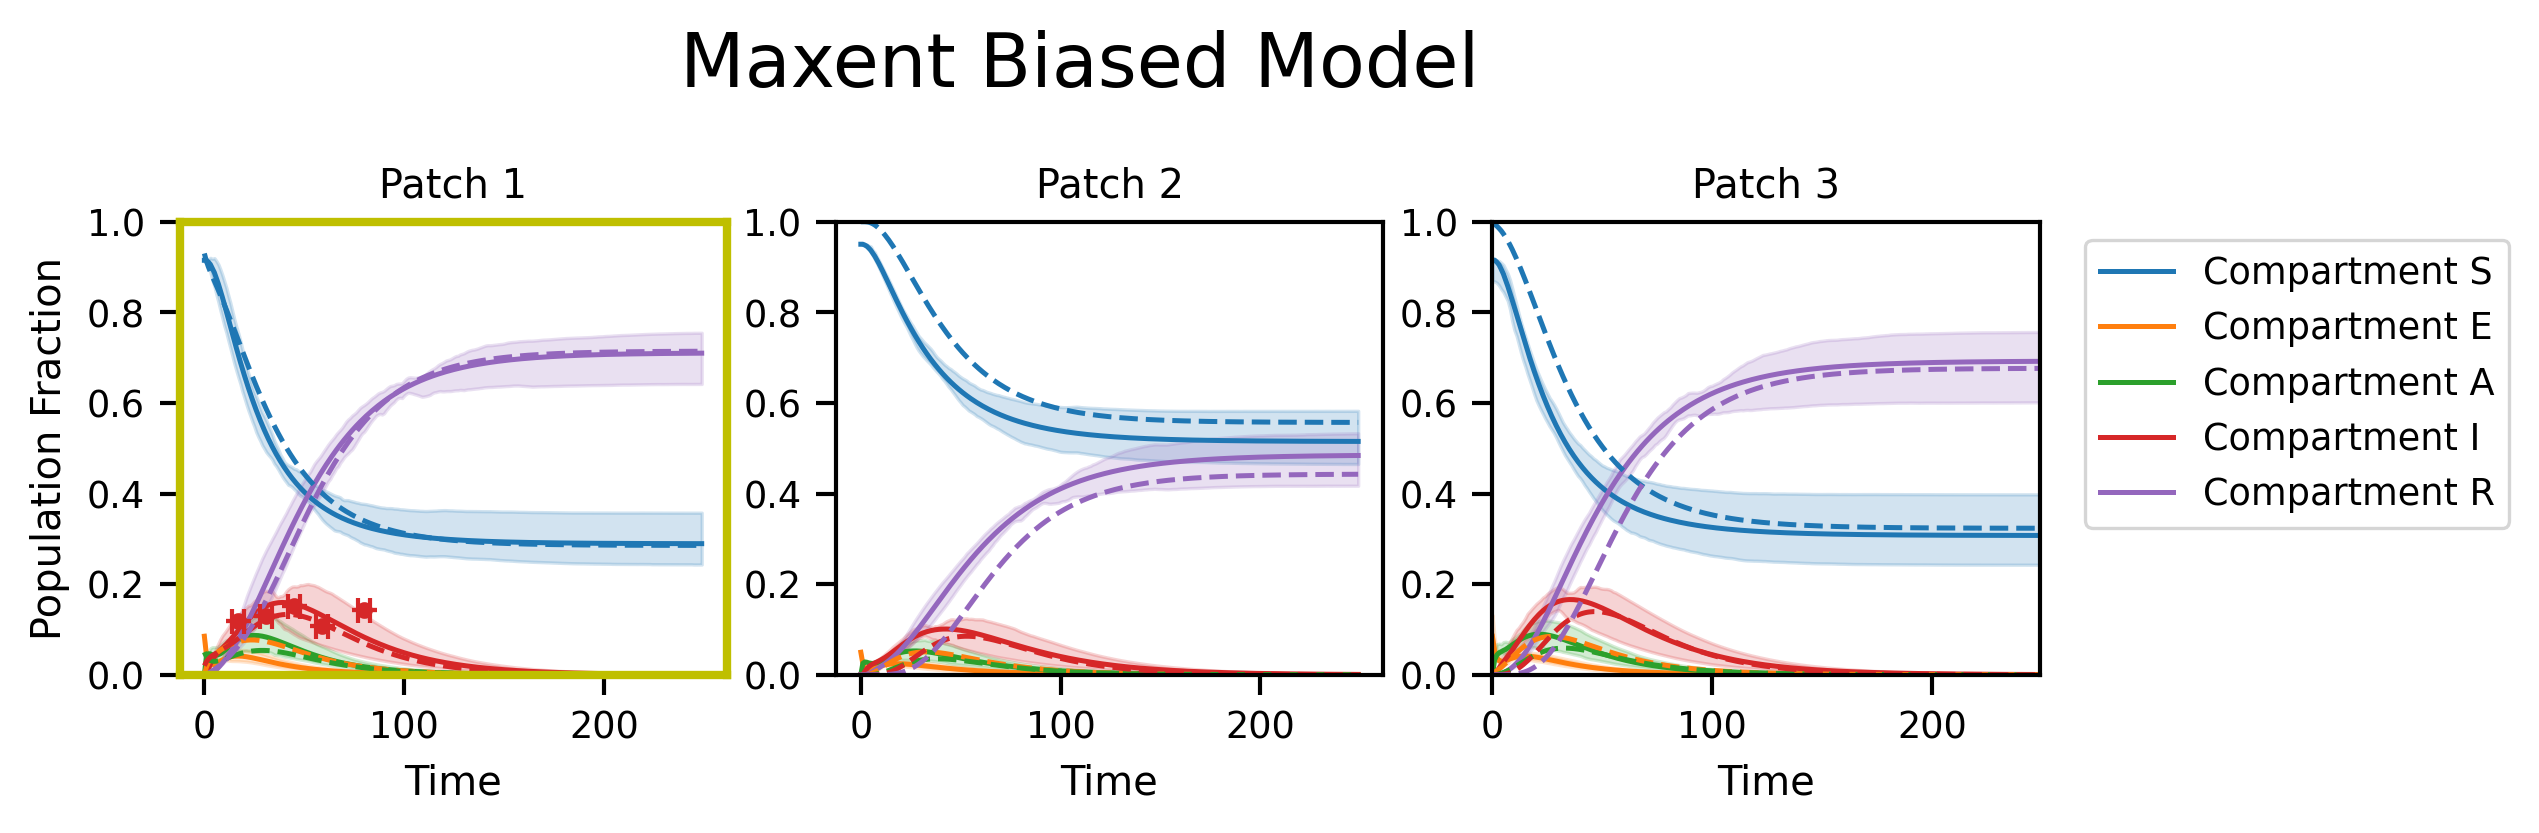

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [10]:
if not USE_CACHED_RESULTS:
    C = len(compartments)
    start = np.zeros((M, C))
    start[0,1] = 0.001
    start[0,2] = 0.001
    beta_start = 0.1
    infect = py0.ContactInfectionLayer(beta_start, infections_compartments)
    # make "agreement" function
    def agreement(traj, rs=restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, agreement)
    rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj = rmodel.get_traj()
    rmodel.fit(timesteps)
    regressed_traj = rmodel.get_traj()
    np.save('epidemiology_files/ls_biased_traj', regressed_traj)
else:
    regressed_traj = np.load('epidemiology_files/ls_biased_traj.npy')

250/250 [==============================] - 13s 46ms/step - loss: 0.0055 - output_2_loss: 0.0055


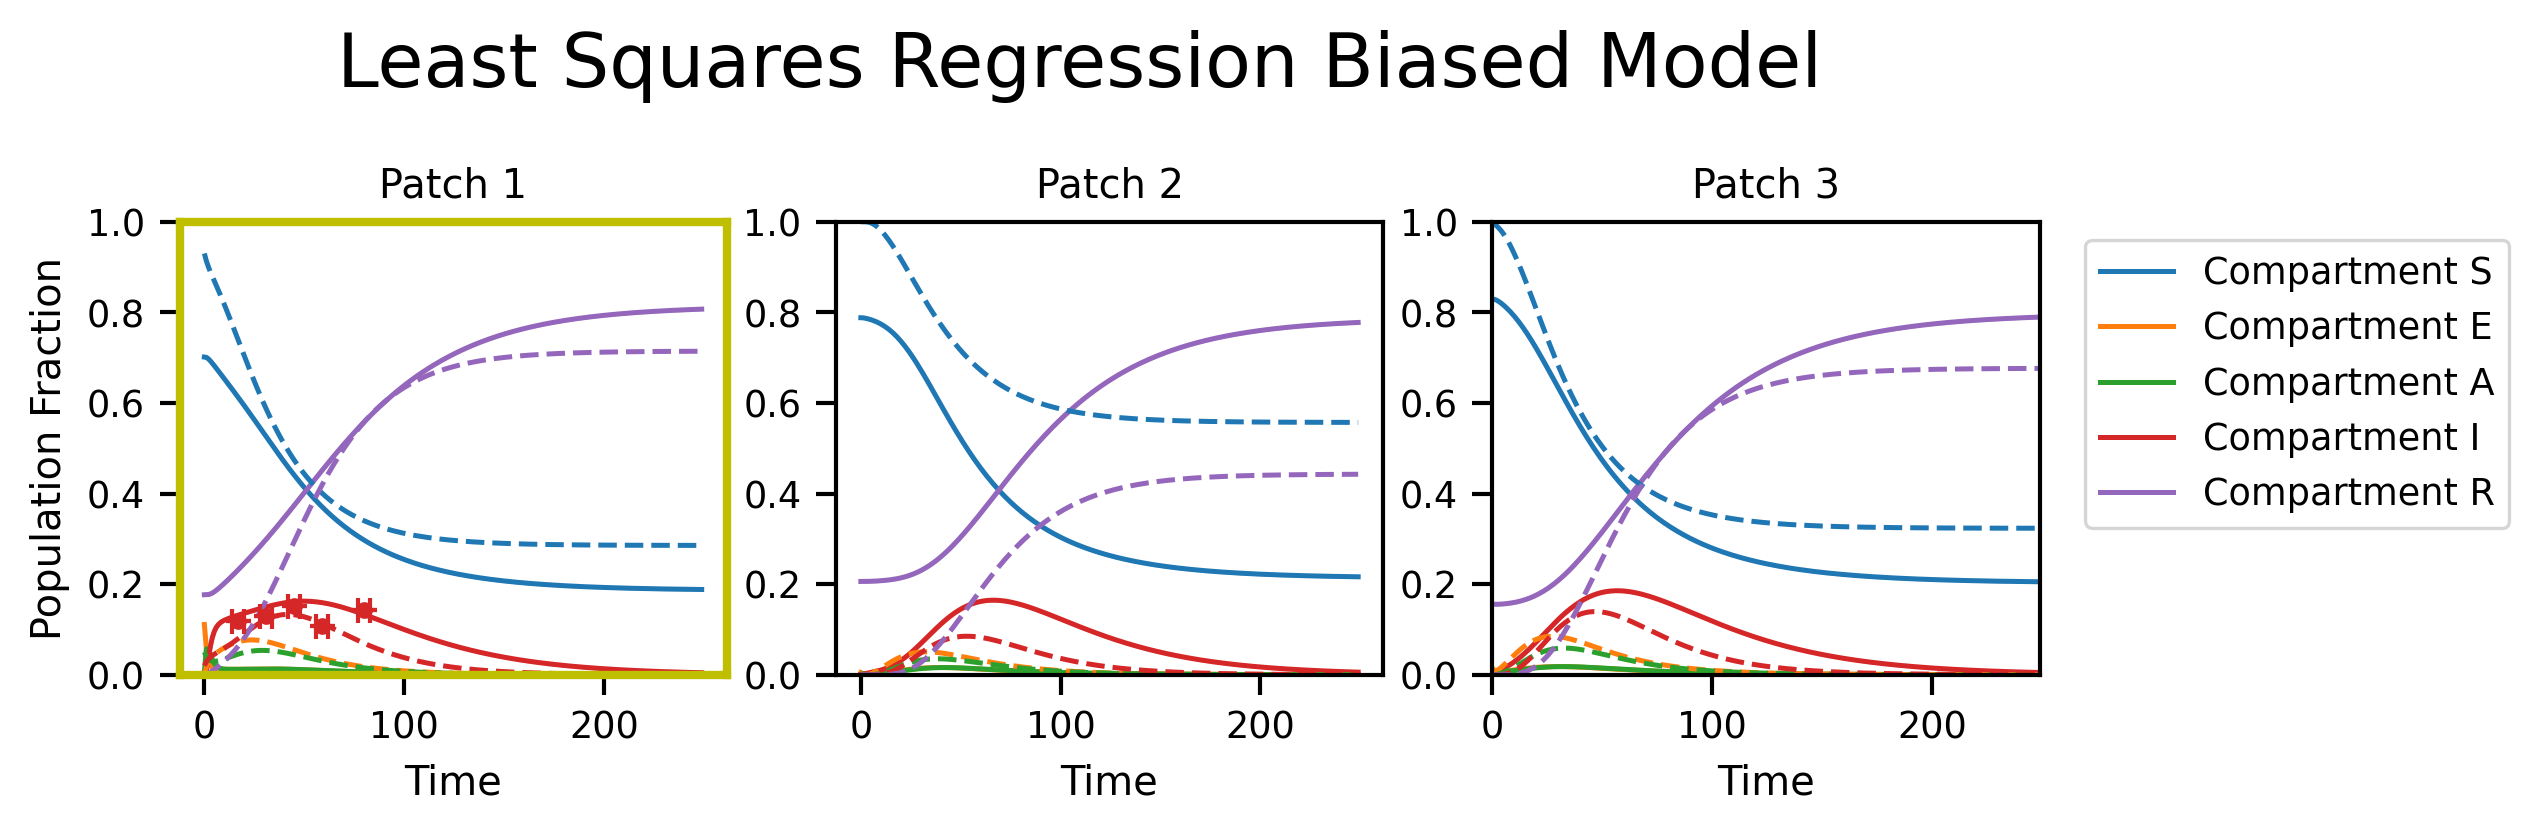

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regression Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## abc

In [12]:
np.random.seed(0)
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10
abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def abc_model(parameter):
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
if not USE_CACHED_RESULTS:
    parameter_priors = pyabc.Distribution(
                                    start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                    start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                    E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                    A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                    I_time=pyabc.RV('norm', abc_param_values[4], 5))

    abc = pyabc.ABCSMC(abc_model, parameter_priors, distance, sampler=pyabc.sampler.base.Sampler)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db') 
    observation = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation})
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    df, w_abc = history.get_distribution(m=0, t=history.max_t)
    abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
    for i, row in enumerate(tqdm.tqdm(np.array(df))):
        A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
        traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
        abc_trajs[i] = traj
    abc_biased_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
    np.save('epidemiology_files/abc_biased_traj.npy', abc_biased_traj)
else:
    abc_biased_traj = np.load('epidemiology_files/abc_biased_traj.npy')

INFO:History:Start <ABCSMC(id=7, start_time=2021-08-03 13:53:16.604245, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.5439328821260495
INFO:ABC:t: 0, eps: 0.5439328821260495.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.40052622986037184.
INFO:ABC:Acceptance rate: 100 / 250 = 4.0000e-01, ESS=4.4232e+01.
INFO:ABC:t: 2, eps: 0.34309395277645505.
INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=6.2148e+01.
INFO:ABC:t: 3, eps: 0.29271979751676147.
INFO:ABC:Acceptance rate: 100 / 225 = 4.4444e-01, ESS=4.5917e+01.
INFO:ABC:t: 4, eps: 0.2537313563454593.
INFO:ABC:Acceptance rate: 100 / 224 = 4.4643e-01, ESS=5.4782e+01.
INFO:History:Done <ABCSMC(id=7, start_time=2021-08-03 13:53:16.604245, end_time=2021-08-03 14:03:07.645526)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/1

## 5-fold cross validation

In [13]:
if not USE_CACHED_RESULTS:
    LS_traj_folds = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
    MaxEnt_traj_folds = np.empty_like(LS_traj_folds)
    abc_traj_folds = []
    for i in range(npoints):
        sampled_restraints = [n for n in restraints if n != restraints[i]]
        ## MaxEnt
        print(f'Initializing LS for fold {i}')
        def new_agreement(traj, rs=sampled_restraints):
            s = 0
            for r in rs:
                s += r(traj[0])**2
            return s
        rmodel_sampled = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, new_agreement)
        rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
        utraj_sampled = rmodel_sampled.get_traj()
        rmodel_sampled.fit(timesteps)
        regressed_traj_sampled = rmodel_sampled.get_traj()
        LS_traj_folds[i,:,:,:] = regressed_traj_sampled
        ## MaxEnt
        print(f'Initializing MaxEnt for fold {i}')
        me_model_sample = py0.MaxentModel(sampled_restraints, trajs=trajs, population_fraction=population_fraction)
        me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
        me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size, epochs=1000)
        MaxEnt_traj_folds[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        ## ABC
        print(f'Initializing ABC for fold {i}')
        def abc_model(parameter):
            trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']),
                                        + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time']))
            restrainted_time_values = [59, 45, 31, 80, 17]
            restrainted_time_values.pop(i)
            values = np.array([trajectory[m, 0, 3].numpy()
                               for m in restrainted_time_values])
            return {'data': values}
        parameter_priors = pyabc.Distribution(
                                        start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                        start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                        E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                        A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                        I_time=pyabc.RV('norm', abc_param_values[4], 5))

        abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
        db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db')
        observation_abc = np.array([r.target for r in sampled_restraints])
        abc.new(db_path, {'data': observation_abc})
        history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
        df, w_abc = history.get_distribution(m=0, t=history.max_t)
        abc_trajs = np.empty(
            (len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
        for j, row in enumerate(tqdm.tqdm(np.array(df))):
            A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc = row[
                0], row[1], row[2], row[3], row[4]
            traj = metapop_wraper(
                abs(start_infected_abc), abs(start_asymptomatic_abc), E_time_abc, A_time_abc, I_time_abc)
            abc_trajs[j] = traj
        mean_abc_traj = np.sum(
                abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        abc_traj_folds.append(mean_abc_traj)
    np.save('epidemiology_files/abc_traj_folds.npy', abc_traj_folds)
    np.save('epidemiology_files/MaxEnt_traj_folds.npy', MaxEnt_traj_folds)
    np.save('epidemiology_files/LS_traj_folds.npy', LS_traj_folds)
abc_traj_folds = np.load('epidemiology_files/abc_traj_folds.npy')
MaxEnt_traj_folds = np.load('epidemiology_files/MaxEnt_traj_folds.npy')
LS_traj_folds = np.load('epidemiology_files/LS_traj_folds.npy')

Initializing LS for fold 0
250/250 [==============================] - 14s 49ms/step - loss: 0.0033 - output_2_loss: 0.0033
Initializing MaxEnt for fold 0
Epoch 1/1000
1/1 [==============================] - 0s 466ms/step - loss: 0.0044 - weight-entropy: 9.0109
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 9.0108
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - weight-entropy: 9.0103
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042 - weight-entropy: 9.0096
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0042 - weight-entropy: 9.0086
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 9.0073
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041 - weight-entropy: 9.0057
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 9.0038
Epoch 9/1000

1/1 [==============================] - 0s 4ms/step - loss: 0.0021 - weight-entropy: 8.3486
Epoch 155/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 8.3457
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 8.3428
Epoch 157/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 8.3400
Epoch 158/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 8.3371
Epoch 159/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 8.3343
Epoch 160/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 8.3315
Epoch 161/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 8.3287
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 8.3260
Epoch 163/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0315
Epoch 309/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0296
Epoch 310/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0278
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0259
Epoch 312/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0241
Epoch 313/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0222
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0204
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0186
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0167
Epoch 317/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7267
Epoch 463/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7246
Epoch 464/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7224
Epoch 465/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7203
Epoch 466/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7182
Epoch 467/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7161
Epoch 468/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7140
Epoch 469/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.7119
Epoch 470/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.7098
Epoch 471/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4253
Epoch 617/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 7.4238
Epoch 618/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 7.4222
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4206
Epoch 620/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4191
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4175
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4160
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4144
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 7.4129
Epoch 625/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.2906
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.2905
Epoch 772/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.2903
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.2902
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.2901
Epoch 775/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.2900
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.2899
Epoch 777/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.2898
Epoch 778/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.2897
Epoch 779/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.2870
Epoch 925/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.2863
Epoch 926/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.2857
Epoch 927/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.2850
Epoch 928/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.2843
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.2836
Epoch 930/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.2828
Epoch 931/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.2821
Epoch 932/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 7.2813
Epoch 933/1000
1/1 [==============================] - 0s 2ms/

INFO:History:Start <ABCSMC(id=8, start_time=2021-08-03 14:04:22.271048, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.39796580667365444
INFO:ABC:t: 0, eps: 0.39796580667365444.
INFO:ABC:Acceptance rate: 100 / 232 = 4.3103e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3060574828289511.
INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=4.7996e+01.
INFO:ABC:t: 2, eps: 0.26752271068905087.
INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=3.5089e+01.
INFO:ABC:t: 3, eps: 0.23666598511460882.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=6.6206e+01.
INFO:ABC:t: 4, eps: 0.20583522321013592.
INFO:ABC:Acceptance rate: 100 / 220 = 4.5455e-01, ESS=4.6842e+01.
INFO:History:Done <ABCSMC(id=8, start_time=2021-08-03 14:04:22.271048, end_time=2021-08-03 14:14:29.805441)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100

Initializing LS for fold 1
250/250 [==============================] - 14s 49ms/step - loss: 0.0039 - output_2_loss: 0.0039
Initializing MaxEnt for fold 1
Epoch 1/1000
1/1 [==============================] - 0s 289ms/step - loss: 0.0041 - weight-entropy: 9.0109
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 9.0108
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 9.0098
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 9.0090
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 9.0078
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0038 - weight-entropy: 9.0065
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 9.0049
Epoch 9/1000

1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2548
Epoch 155/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2519
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2491
Epoch 157/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2462
Epoch 158/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - weight-entropy: 8.2435
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2407
Epoch 160/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2381
Epoch 161/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 8.2354
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.2328
Epoch 163/1000
1/1 [==============================] - 0s 3m

1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0226
Epoch 309/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0216
Epoch 310/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0206
Epoch 311/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0197
Epoch 312/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0187
Epoch 313/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0177
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0168
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 8.0158
Epoch 316/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - weight-entropy: 8.0149
Epoch 317/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9186
Epoch 463/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9182
Epoch 464/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9178
Epoch 465/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9174
Epoch 466/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9171
Epoch 467/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.9167
Epoch 468/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 7.9163
Epoch 469/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.9160
Epoch 470/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 7.9156
Epoch 471/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 7.8766
Epoch 617/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 7.8762
Epoch 618/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 7.8759
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 7.8756
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 7.8753
Epoch 621/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 7.8750
Epoch 622/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 7.8746
Epoch 623/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 7.8743
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 7.8740
Epoch 625/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.7731
Epoch 771/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.7720
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.7709
Epoch 773/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.7697
Epoch 774/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.7686
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.7674
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.7663
Epoch 777/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 7.7651
Epoch 778/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 7.7639
Epoch 779/1000
1/1 [==============================] - 0s 3ms/

Epoch 923/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5298
Epoch 924/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5278
Epoch 925/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5258
Epoch 926/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5238
Epoch 927/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5218
Epoch 928/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5197
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5177
Epoch 930/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5157
Epoch 931/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 7.5136
Epoch 932/1000
1/1 [==========================

INFO:History:Start <ABCSMC(id=9, start_time=2021-08-03 14:15:45.235453, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.40796208127687217
INFO:ABC:t: 0, eps: 0.40796208127687217.
INFO:ABC:Acceptance rate: 100 / 188 = 5.3191e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.30945099740286375.
INFO:ABC:Acceptance rate: 100 / 222 = 4.5045e-01, ESS=4.4315e+01.
INFO:ABC:t: 2, eps: 0.25967333004595794.
INFO:ABC:Acceptance rate: 100 / 270 = 3.7037e-01, ESS=5.2772e+01.
INFO:ABC:t: 3, eps: 0.2249509527183923.
INFO:ABC:Acceptance rate: 100 / 237 = 4.2194e-01, ESS=4.6031e+01.
INFO:ABC:t: 4, eps: 0.1951672509381434.
INFO:ABC:Acceptance rate: 100 / 243 = 4.1152e-01, ESS=5.4512e+01.
INFO:History:Done <ABCSMC(id=9, start_time=2021-08-03 14:15:45.235453, end_time=2021-08-03 14:26:20.614867)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/

Initializing LS for fold 2
250/250 [==============================] - 13s 45ms/step - loss: 0.0051 - output_2_loss: 0.0051
Initializing MaxEnt for fold 2
Epoch 1/1000
1/1 [==============================] - 0s 264ms/step - loss: 0.0050 - weight-entropy: 9.0109
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 9.0108
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 9.0098
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 9.0089
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 9.0078
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046 - weight-entropy: 9.0064
Epoch 8/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046 - weight-entropy: 9.0047
Epoch 9/1000

1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0644
Epoch 155/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0639
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0633
Epoch 157/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0628
Epoch 158/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0624
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0620
Epoch 160/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0616
Epoch 161/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0612
Epoch 162/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0609
Epoch 163/1000
1/1 [==============================] - 0s 2ms/

Epoch 308/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 309/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 310/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 312/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 313/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0615
Epoch 317/1000
1/1 [==========================

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0606
Epoch 463/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 464/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 465/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 466/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 467/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 468/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 469/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0605
Epoch 471/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0590
Epoch 617/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0590
Epoch 618/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0590
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 621/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 622/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 624/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0589
Epoch 625/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0565
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0565
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0565
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0565
Epoch 774/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0564
Epoch 775/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0564
Epoch 776/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0564
Epoch 777/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0564
Epoch 778/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0564
Epoch 779/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0528
Epoch 925/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0527
Epoch 926/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0527
Epoch 927/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0527
Epoch 928/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0527
Epoch 929/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0526
Epoch 930/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0526
Epoch 931/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.0526
Epoch 932/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0525
Epoch 933/1000
1/1 [==============================] - 0s 3ms/

Initializing ABC for fold 2


INFO:History:Start <ABCSMC(id=10, start_time=2021-08-03 14:27:29.931615, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4445733636641138
INFO:ABC:t: 0, eps: 0.4445733636641138.
INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3462212867586003.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=1.8680e+01.
INFO:ABC:t: 2, eps: 0.30813337840916616.
INFO:ABC:Acceptance rate: 100 / 234 = 4.2735e-01, ESS=1.9906e+01.
INFO:ABC:t: 3, eps: 0.2730590336707012.
INFO:ABC:Acceptance rate: 100 / 188 = 5.3191e-01, ESS=6.3834e+01.
INFO:ABC:t: 4, eps: 0.2403810277246863.
INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=6.6779e+01.
INFO:History:Done <ABCSMC(id=10, start_time=2021-08-03 14:27:29.931615, end_time=2021-08-03 14:36:07.646996)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/1

Initializing LS for fold 3
250/250 [==============================] - 12s 44ms/step - loss: 0.0014 - output_2_loss: 0.0014
Initializing MaxEnt for fold 3
Epoch 1/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.0017 - weight-entropy: 9.0109
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 9.0107
Epoch 3/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - weight-entropy: 9.0102
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 9.0093
Epoch 5/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0014 - weight-entropy: 9.0080
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 9.0064
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 9.0044
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 9.0021
Epoch 9/

1/1 [==============================] - 0s 3ms/step - loss: 3.6770e-04 - weight-entropy: 8.7264
Epoch 150/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.6755e-04 - weight-entropy: 8.7261
Epoch 151/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6739e-04 - weight-entropy: 8.7258
Epoch 152/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6724e-04 - weight-entropy: 8.7255
Epoch 153/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6709e-04 - weight-entropy: 8.7252
Epoch 154/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6695e-04 - weight-entropy: 8.7249
Epoch 155/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6681e-04 - weight-entropy: 8.7246
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.6668e-04 - weight-entropy: 8.7243
Epoch 157/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.6655e-04 - weight-entropy: 8.7241
Epoch 158/1000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 3.5905e-04 - weight-entropy: 8.7064
Epoch 298/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5902e-04 - weight-entropy: 8.7063
Epoch 299/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5898e-04 - weight-entropy: 8.7063
Epoch 300/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5894e-04 - weight-entropy: 8.7063
Epoch 301/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5891e-04 - weight-entropy: 8.7062
Epoch 302/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5887e-04 - weight-entropy: 8.7062
Epoch 303/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5883e-04 - weight-entropy: 8.7062
Epoch 304/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5879e-04 - weight-entropy: 8.7061
Epoch 305/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5876e-04 - weight-entropy: 8.7061
Epoch 306/1000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 3.5281e-04 - weight-entropy: 8.7040
Epoch 446/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5277e-04 - weight-entropy: 8.7040
Epoch 447/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5272e-04 - weight-entropy: 8.7040
Epoch 448/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5268e-04 - weight-entropy: 8.7040
Epoch 449/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5262e-04 - weight-entropy: 8.7040
Epoch 450/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5258e-04 - weight-entropy: 8.7040
Epoch 451/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5253e-04 - weight-entropy: 8.7039
Epoch 452/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.5248e-04 - weight-entropy: 8.7039
Epoch 453/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.5243e-04 - weight-entropy: 8.7039
Epoch 454/1000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 3.4497e-04 - weight-entropy: 8.7018
Epoch 594/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4491e-04 - weight-entropy: 8.7018
Epoch 595/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4485e-04 - weight-entropy: 8.7018
Epoch 596/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4479e-04 - weight-entropy: 8.7017
Epoch 597/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4473e-04 - weight-entropy: 8.7017
Epoch 598/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4468e-04 - weight-entropy: 8.7017
Epoch 599/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.4462e-04 - weight-entropy: 8.7017
Epoch 600/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4456e-04 - weight-entropy: 8.7017
Epoch 601/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.4450e-04 - weight-entropy: 8.7016
Epoch 602/1000
1/1 [=====

1/1 [==============================] - 0s 996us/step - loss: 3.3545e-04 - weight-entropy: 8.6976
Epoch 742/1000
1/1 [==============================] - 0s 998us/step - loss: 3.3538e-04 - weight-entropy: 8.6976
Epoch 743/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3531e-04 - weight-entropy: 8.6976
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3524e-04 - weight-entropy: 8.6975
Epoch 745/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3517e-04 - weight-entropy: 8.6975
Epoch 746/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3510e-04 - weight-entropy: 8.6975
Epoch 747/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3502e-04 - weight-entropy: 8.6974
Epoch 748/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.3495e-04 - weight-entropy: 8.6974
Epoch 749/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.3488e-04 - weight-entropy: 8.6974
Epoch 750/1000
1/1 [=

1/1 [==============================] - 0s 3ms/step - loss: 3.2415e-04 - weight-entropy: 8.6906
Epoch 890/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2407e-04 - weight-entropy: 8.6906
Epoch 891/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2399e-04 - weight-entropy: 8.6905
Epoch 892/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2391e-04 - weight-entropy: 8.6904
Epoch 893/1000
1/1 [==============================] - 0s 968us/step - loss: 3.2382e-04 - weight-entropy: 8.6904
Epoch 894/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.2374e-04 - weight-entropy: 8.6903
Epoch 895/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2365e-04 - weight-entropy: 8.6903
Epoch 896/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2357e-04 - weight-entropy: 8.6902
Epoch 897/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.2349e-04 - weight-entropy: 8.6901
Epoch 898/1000
1/1 [===

INFO:History:Start <ABCSMC(id=11, start_time=2021-08-03 14:37:15.852706, end_time=None)>


Initializing ABC for fold 3


INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.3379399741472608
INFO:ABC:t: 0, eps: 0.3379399741472608.
INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.24378640047307001.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01, ESS=6.4202e+01.
INFO:ABC:t: 2, eps: 0.1972780866523622.
INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01, ESS=6.8483e+01.
INFO:ABC:t: 3, eps: 0.15947392736105473.
INFO:ABC:Acceptance rate: 100 / 240 = 4.1667e-01, ESS=2.8616e+01.
INFO:ABC:t: 4, eps: 0.12402058813362725.
INFO:ABC:Acceptance rate: 100 / 260 = 3.8462e-01, ESS=5.9169e+01.
INFO:History:Done <ABCSMC(id=11, start_time=2021-08-03 14:37:15.852706, end_time=2021-08-03 14:48:20.269184)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Initializing LS for fold 4
250/250 [==============================] - 13s 47ms/step - loss: 0.0048 - output_2_loss: 0.0048
Initializing MaxEnt for fold 4
Epoch 1/1000
1/1 [==============================] - 0s 274ms/step - loss: 0.0050 - weight-entropy: 9.0109
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0049 - weight-entropy: 9.0107
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 9.0102
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 9.0093
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 9.0080
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0046 - weight-entropy: 9.0064
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 9.0043
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 9.0019
Epoch 9/1000

1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 8.4098
Epoch 155/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 8.4096
Epoch 156/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 8.4094
Epoch 157/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 8.4092
Epoch 158/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 8.4090
Epoch 159/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 8.4088
Epoch 160/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 8.4086
Epoch 161/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 8.4084
Epoch 162/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 8.4082
Epoch 163/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 8.3418
Epoch 309/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 8.3410
Epoch 310/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.3402
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 8.3393
Epoch 312/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.3385
Epoch 313/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.3377
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 8.3368
Epoch 315/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.3360
Epoch 316/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 8.3351
Epoch 317/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.0894
Epoch 463/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.0866
Epoch 464/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.0838
Epoch 465/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.0809
Epoch 466/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.0781
Epoch 467/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.0752
Epoch 468/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.0723
Epoch 469/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.0694
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.0664
Epoch 471/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.4559
Epoch 617/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.4510
Epoch 618/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.4461
Epoch 619/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.4411
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.4362
Epoch 621/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.4313
Epoch 622/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.4263
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.4214
Epoch 624/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.4165
Epoch 625/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 8.5963e-04 - weight-entropy: 6.8048
Epoch 766/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5891e-04 - weight-entropy: 6.8013
Epoch 767/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5821e-04 - weight-entropy: 6.7979
Epoch 768/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5750e-04 - weight-entropy: 6.7944
Epoch 769/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5681e-04 - weight-entropy: 6.7910
Epoch 770/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.5611e-04 - weight-entropy: 6.7875
Epoch 771/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5542e-04 - weight-entropy: 6.7841
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5476e-04 - weight-entropy: 6.7807
Epoch 773/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.5408e-04 - weight-entropy: 6.7773
Epoch 774/1000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 8.0085e-04 - weight-entropy: 6.4130
Epoch 914/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.0067e-04 - weight-entropy: 6.4111
Epoch 915/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.0047e-04 - weight-entropy: 6.4091
Epoch 916/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.0028e-04 - weight-entropy: 6.4072
Epoch 917/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.0010e-04 - weight-entropy: 6.4053
Epoch 918/1000
1/1 [==============================] - 0s 2ms/step - loss: 7.9990e-04 - weight-entropy: 6.4034
Epoch 919/1000
1/1 [==============================] - 0s 3ms/step - loss: 7.9972e-04 - weight-entropy: 6.4015
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 7.9954e-04 - weight-entropy: 6.3996
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 7.9936e-04 - weight-entropy: 6.3977
Epoch 922/1000
1/1 [=====

INFO:History:Start <ABCSMC(id=12, start_time=2021-08-03 14:49:34.781384, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4997795303682357
INFO:ABC:t: 0, eps: 0.4997795303682357.
INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3242821912747822.
INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=4.3518e+01.
INFO:ABC:t: 2, eps: 0.2574084593643865.
INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=5.1612e+01.
INFO:ABC:t: 3, eps: 0.21687621904139817.
INFO:ABC:Acceptance rate: 100 / 221 = 4.5249e-01, ESS=6.4169e+01.
INFO:ABC:t: 4, eps: 0.19371517583193948.
INFO:ABC:Acceptance rate: 100 / 209 = 4.7847e-01, ESS=2.5051e+01.
INFO:History:Done <ABCSMC(id=12, start_time=2021-08-03 14:49:34.781384, end_time=2021-08-03 14:59:34.854781)>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/

In [14]:
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_traj_folds)
std_MaxEnt = find_std(MaxEnt_traj_folds)
std_LS = find_std(LS_traj_folds)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)


MaxEnt std :  [0.0, 0.01577120570669534, 0.018983195798761756]
Least-squares std :  [0.0263919479418941, 0.06591773929089012, 0.04426152618493399]
ABC std :  [0.0, 0.01017054388373537, 0.014390072825594354]


In [15]:
def weighted_quantile(values, quantiles, sample_weight=None,
                       values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

(250, 3, 5)


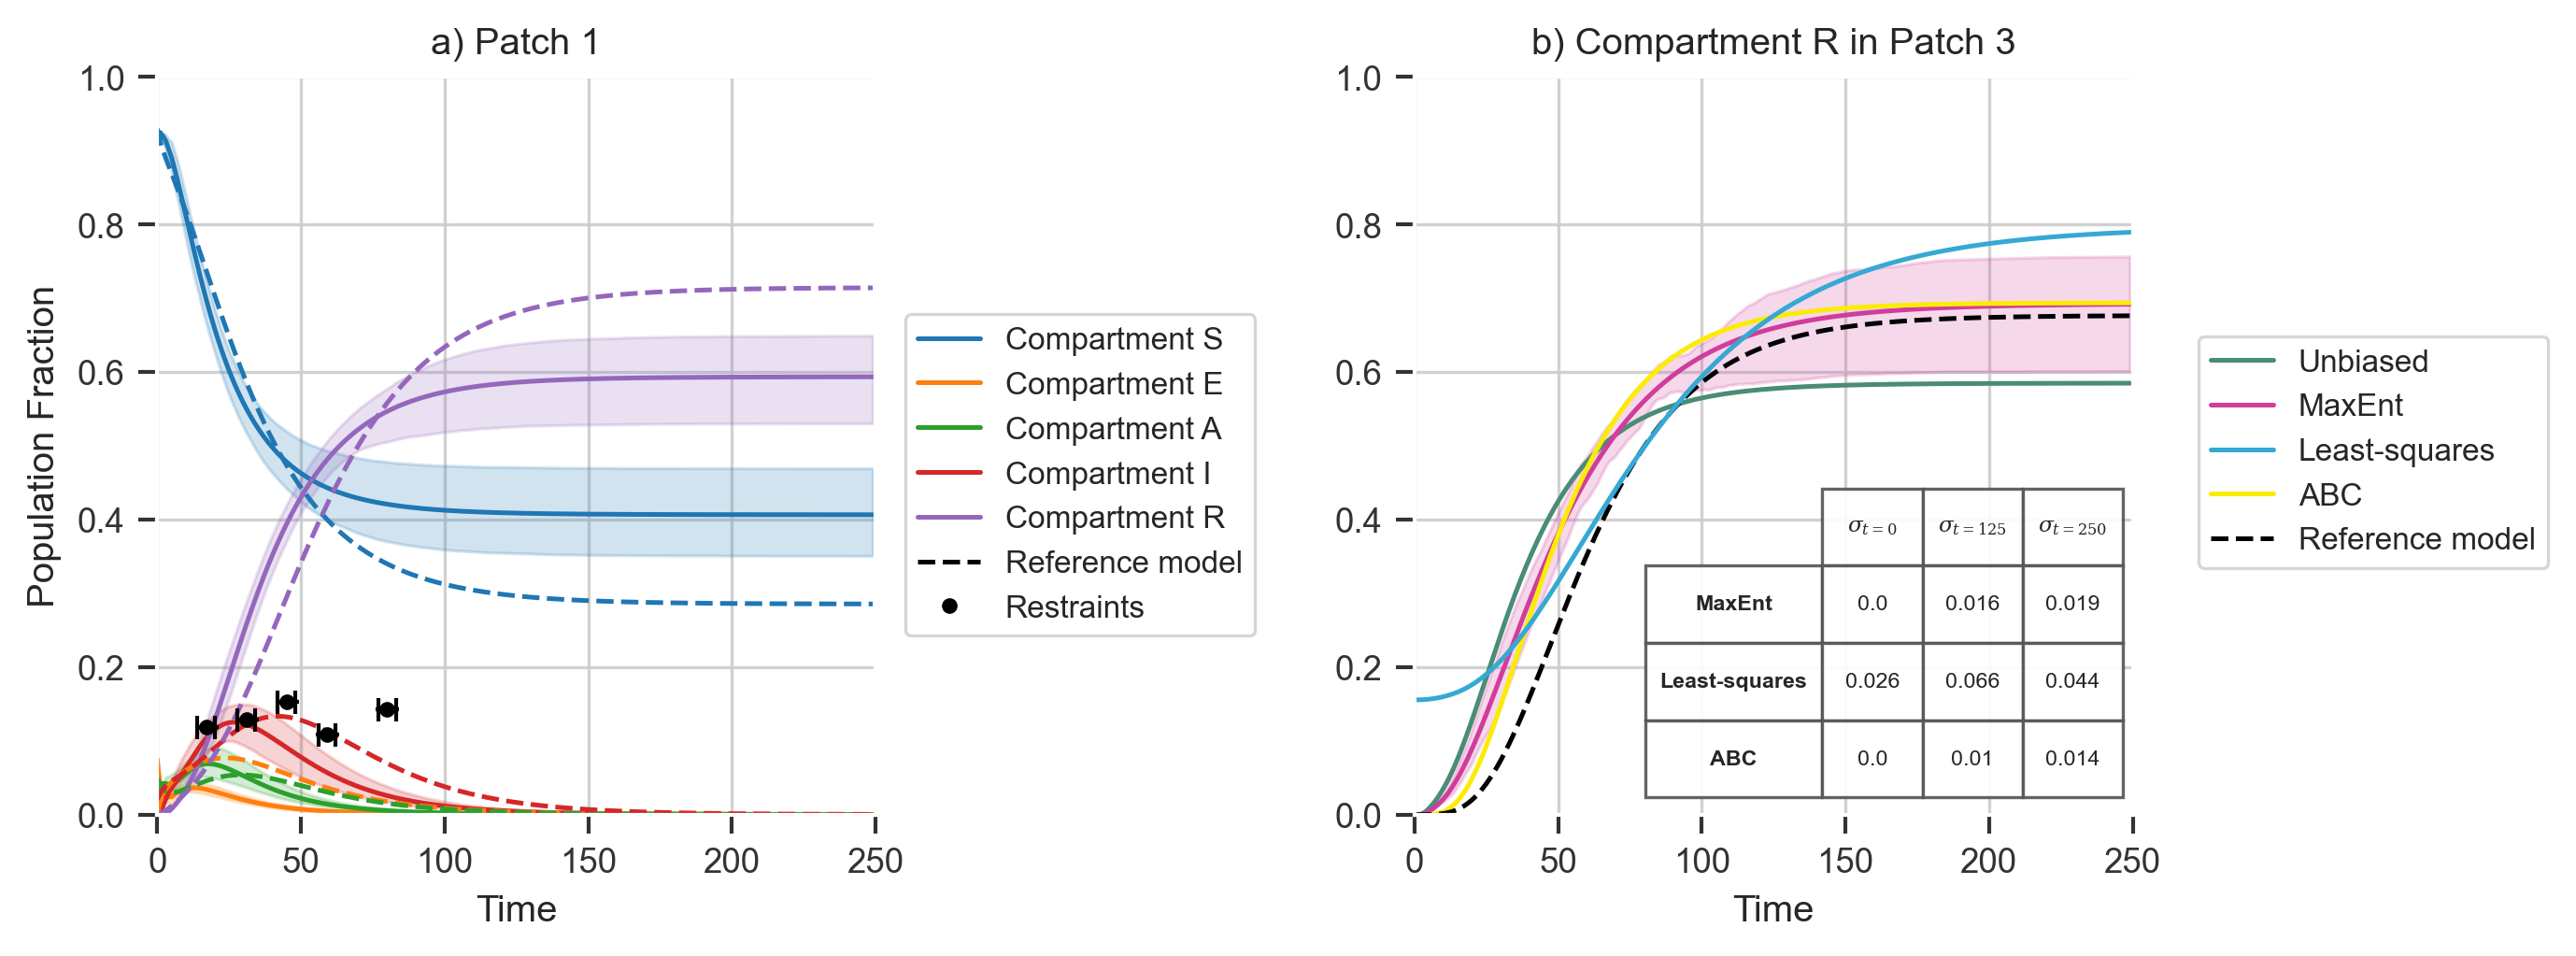

In [16]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(trajs * me_w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
qtrajs_maxentbiased = np.apply_along_axis(lambda x: weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_w), 0, trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)

axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_biased_traj[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])
